In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, Lasso, LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
import pandas as pd
import pickle
import seaborn as sns

from debias_prog import ScaledLasso, DebiasProg, DualObj, DualCD

from sklearn.preprocessing import PolynomialFeatures, StandardScaler, SplineTransformer

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve

### Reading the data

Data model references: 
  - Spectroscopic features: https://data.sdss.org/datamodel/files/SPECTRO_REDUX/specObj.html
  - Photometric features: https://skyserver.sdss.org/dr9/en/help/docs/datamodel.asp
  - Flux and Magnitudes: https://live-sdss4org-dr12.pantheonsite.io/algorithms/magnitudes/

In [2]:
gal = pd.read_csv('SDSS_gal_redshift04.csv')
# Subset a tiny redshift range:
gal_sel = gal.loc[(gal.redshift >= 0.4) & (gal.redshift <= 0.4005)].reset_index()
gal_sel = gal_sel.drop(['index'], axis=1)
gal_sel

,PLATE,MJD,FIBERID,RA,DEC,Z,class_x,comov_dist,dist_DirFila_comov,dist_DirModes_comov,...,spectroSkyFlux_g,spectroSkyFlux_r,spectroSkyFlux_i,spectroSkyFlux_z,sn1_g,sn1_r,sn1_i,sn2_g,sn2_r,sn2_i
0,276,51909,605,164.592420,0.869854,0.400103,GALAXY,1599.581008,46.305838,47.548321,...,10.754010,27.37779,51.89083,89.63586,33.54350,36.7796,32.1816,32.78190,34.1600,30.7545
1,277,51908,430,165.092320,0.105792,0.400166,GALAXY,1599.805536,59.328475,59.601530,...,12.033520,28.34640,49.52873,83.76037,22.90730,23.8706,21.8558,22.67280,24.5531,21.3639
2,287,52023,61,184.321390,-0.694287,0.400170,GALAXY,1599.822120,88.362387,114.134775,...,16.260960,58.22731,116.79060,191.23240,25.47440,22.8106,18.8935,24.27190,23.7287,17.7534
3,332,52367,418,182.329980,-1.363539,0.400028,GALAXY,1599.312456,119.061377,135.228309,...,25.938140,41.19625,68.08878,109.79030,12.34790,15.3585,15.0301,15.85420,17.0893,16.5449
4,333,52313,466,184.597940,-2.591683,0.400084,GALAXY,1599.514456,137.903700,165.815928,...,18.350670,42.46152,106.56250,176.50630,23.98520,23.5645,15.9296,25.11090,25.6476,18.1091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1180,9152,58041,725,344.587688,-0.170328,0.400455,GALAXY,1600.836217,10.874511,44.469521,...,9.424508,19.04390,35.56932,100.23230,11.10470,30.2806,20.8821,14.70790,52.4335,45.5913
1181,9332,58072,158,18.129801,-2.517902,0.400268,GALAXY,1600.171546,24.855427,109.012134,...,10.266040,26.08511,52.27619,130.63530,13.25230,40.3324,30.2996,11.65200,36.7413,27.8943
1182,9413,58080,828,10.857364,2.209474,0.400410,GALAXY,1600.677948,16.835685,64.093658,...,10.448960,25.48484,52.18871,144.83090,9.50382,27.9141,18.4340,9.24656,31.8079,21.2454
1183,9417,58055,815,41.199377,2.372282,0.400463,GALAXY,1600.864915,12.867415,70.287687,...,9.932518,25.44989,48.46449,117.53500,12.69750,34.1688,24.3525,13.04910,44.2771,35.7455


In [36]:
gal.loc[(gal.redshift > 0.4005)].shape

(1050, 109)

In [46]:
np.random.choice(gal.loc[(gal.redshift > 0.4005)].shape[0], size=1)[0]

773

In [3]:
gal_new = gal.loc[gal.redshift > 0.4005]
x_gal = gal_new.iloc[1000]
print(x_gal.redshift)
print(x_gal.Chabrier_MILES_total_mass)

## Append the new galaxy to the data frame
gal_sel.loc[len(gal_sel.index)] = list(x_gal)
gal_sel

0.400911
188449212248.3586


,PLATE,MJD,FIBERID,RA,DEC,Z,class_x,comov_dist,dist_DirFila_comov,dist_DirModes_comov,...,spectroSkyFlux_g,spectroSkyFlux_r,spectroSkyFlux_i,spectroSkyFlux_z,sn1_g,sn1_r,sn1_i,sn2_g,sn2_r,sn2_i
0,276,51909,605,164.592420,0.869854,0.400103,GALAXY,1599.581008,46.305838,47.548321,...,10.754010,27.37779,51.89083,89.63586,33.54350,36.7796,32.1816,32.78190,34.1600,30.7545
1,277,51908,430,165.092320,0.105792,0.400166,GALAXY,1599.805536,59.328475,59.601530,...,12.033520,28.34640,49.52873,83.76037,22.90730,23.8706,21.8558,22.67280,24.5531,21.3639
2,287,52023,61,184.321390,-0.694287,0.400170,GALAXY,1599.822120,88.362387,114.134775,...,16.260960,58.22731,116.79060,191.23240,25.47440,22.8106,18.8935,24.27190,23.7287,17.7534
3,332,52367,418,182.329980,-1.363539,0.400028,GALAXY,1599.312456,119.061377,135.228309,...,25.938140,41.19625,68.08878,109.79030,12.34790,15.3585,15.0301,15.85420,17.0893,16.5449
4,333,52313,466,184.597940,-2.591683,0.400084,GALAXY,1599.514456,137.903700,165.815928,...,18.350670,42.46152,106.56250,176.50630,23.98520,23.5645,15.9296,25.11090,25.6476,18.1091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1181,9332,58072,158,18.129801,-2.517902,0.400268,GALAXY,1600.171546,24.855427,109.012134,...,10.266040,26.08511,52.27619,130.63530,13.25230,40.3324,30.2996,11.65200,36.7413,27.8943
1182,9413,58080,828,10.857364,2.209474,0.400410,GALAXY,1600.677948,16.835685,64.093658,...,10.448960,25.48484,52.18871,144.83090,9.50382,27.9141,18.4340,9.24656,31.8079,21.2454
1183,9417,58055,815,41.199377,2.372282,0.400463,GALAXY,1600.864915,12.867415,70.287687,...,9.932518,25.44989,48.46449,117.53500,12.69750,34.1688,24.3525,13.04910,44.2771,35.7455
1184,9425,58136,322,30.808962,2.522140,0.400420,GALAXY,1600.711749,34.968560,49.577852,...,8.782398,18.13220,35.26272,98.89027,11.17740,34.6226,24.8999,12.67890,38.4763,28.8125


Notes: the missing values in 'Chabrier_MILES_total_mass' are recorded as -9999. 

In [4]:
Y = gal_sel['Chabrier_MILES_total_mass'].values
R = np.ones((len(Y),))
R[Y <= 0] = 0
log_Y = np.log(Y)
log_Y[Y <= 0] = -9999

# Subset all the covariates
dat = gal_sel[['RA', 'DEC', 'dist_DirFila_angdiam', 'dist_DirKnots_angdiam', 'dist_DirModes_angdiam', 
               'err_u','err_g','err_r','err_i','err_z', 
               'u','g','r','i','z',
               'modelMag_u','modelMag_g','modelMag_r','modelMag_i','modelMag_z',
               'cModelMag_u','cModelMag_g','cModelMag_r','cModelMag_i','cModelMag_z',
               'extinction_u', 'extinction_g','extinction_r','extinction_i','extinction_z', 
               'spectroFlux_u', 'spectroFlux_g', 'spectroFlux_r', 'spectroFlux_i', 'spectroFlux_z', 
               'spectroFluxIvar_u', 'spectroFluxIvar_g', 'spectroFluxIvar_r', 'spectroFluxIvar_i', 'spectroFluxIvar_z', 
               'spectroSynFlux_u', 'spectroSynFlux_g', 'spectroSynFlux_r', 'spectroSynFlux_i', 'spectroSynFlux_z', 
               'spectroSynFluxIvar_u', 'spectroSynFluxIvar_g', 'spectroSynFluxIvar_r', 'spectroSynFluxIvar_i', 
               'spectroSynFluxIvar_z', 
               'spectroSkyFlux_u', 'spectroSkyFlux_g', 'spectroSkyFlux_r', 'spectroSkyFlux_i', 'spectroSkyFlux_z', 
               'sn1_g', 'sn1_r', 'sn1_i', 'sn2_g', 'sn2_r', 'sn2_i', 
               'snMedian_u', 'snMedian_g', 'snMedian_r', 'snMedian_i', 'snMedian_z', 'snMedian']]


def signlog(x):
    return np.sign(x) * np.log(1 + np.abs(x))

dat['u_log'] = signlog(dat['u'])
dat['g_log'] = signlog(dat['g'])
dat['r_log'] = signlog(dat['r'])
dat['i_log'] = signlog(dat['i'])
dat['z_log'] = signlog(dat['z'])

dat['extinction_u_log'] = signlog(dat['extinction_u'])
dat['extinction_g_log'] = signlog(dat['extinction_g'])
dat['extinction_r_log'] = signlog(dat['extinction_r'])
dat['extinction_i_log'] = signlog(dat['extinction_i'])
dat['extinction_z_log'] = signlog(dat['extinction_z'])

dat['spectroFlux_u_log'] = signlog(dat['spectroFlux_u'])
dat['spectroFlux_g_log'] = signlog(dat['spectroFlux_g'])
dat['spectroFlux_r_log'] = signlog(dat['spectroFlux_r'])
dat['spectroFlux_i_log'] = signlog(dat['spectroFlux_i'])
dat['spectroFlux_z_log'] = signlog(dat['spectroFlux_z'])

dat['spectroSynFlux_u_log'] = signlog(dat['spectroSynFlux_u'])
dat['spectroSynFlux_g_log'] = signlog(dat['spectroSynFlux_g'])
dat['spectroSynFlux_r_log'] = signlog(dat['spectroSynFlux_r'])
dat['spectroSynFlux_i_log'] = signlog(dat['spectroSynFlux_i'])
dat['spectroSynFlux_z_log'] = signlog(dat['spectroSynFlux_z'])

dat['spectroSkyFlux_u_log'] = signlog(dat['spectroSkyFlux_u'])
dat['spectroSkyFlux_g_log'] = signlog(dat['spectroSkyFlux_g'])
dat['spectroSkyFlux_r_log'] = signlog(dat['spectroSkyFlux_r'])
dat['spectroSkyFlux_i_log'] = signlog(dat['spectroSkyFlux_i'])
dat['spectroSkyFlux_z_log'] = signlog(dat['spectroSkyFlux_z'])

dat

/tmp/ipykernel_309242/3770991404.py:4: RuntimeWarning: invalid value encountered in log
  log_Y = np.log(Y)
/tmp/ipykernel_309242/3770991404.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat['u_log'] = signlog(dat['u'])
/tmp/ipykernel_309242/3770991404.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat['g_log'] = signlog(dat['g'])
/tmp/ipykernel_309242/3770991404.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

,RA,DEC,dist_DirFila_angdiam,dist_DirKnots_angdiam,dist_DirModes_angdiam,err_u,err_g,err_r,err_i,err_z,...,spectroSynFlux_u_log,spectroSynFlux_g_log,spectroSynFlux_r_log,spectroSynFlux_i_log,spectroSynFlux_z_log,spectroSkyFlux_u_log,spectroSkyFlux_g_log,spectroSkyFlux_r_log,spectroSkyFlux_i_log,spectroSkyFlux_z_log
0,164.592420,0.869854,32.348181,66.839842,33.253091,0.883961,0.058272,0.021677,0.018013,0.040937,...,0.401727,1.055538,2.437968,3.018978,3.326595,1.849118,2.464194,3.345607,3.968230,4.506850
1,165.092320,0.105792,41.765274,84.426986,41.962709,1.859456,0.042287,0.015816,0.012527,0.034158,...,0.432600,1.297396,2.736930,3.389868,3.746164,1.929354,2.567525,3.379170,3.922542,4.439828
2,184.321390,-0.694287,62.667742,111.450461,81.148526,3.830184,0.076067,0.020063,0.016462,0.037736,...,-0.063325,0.787389,2.320237,2.993950,3.366116,1.801197,2.848447,4.081383,4.768908,5.258705
3,182.329980,-1.363539,84.719610,97.069669,96.294433,0.674352,0.049194,0.017672,0.016470,0.040522,...,0.313904,1.215004,2.688002,3.334665,3.671170,2.566778,3.293543,3.742331,4.235392,4.707639
4,184.597940,-2.591683,98.193659,141.426031,118.169733,0.486544,0.066981,0.023436,0.019496,0.066391,...,0.216008,0.748270,2.160481,2.829401,3.227351,2.530823,2.962727,3.771876,4.678072,5.179006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1181,18.129801,-2.517902,16.370588,75.981469,77.647190,0.272953,0.108002,0.081126,0.083348,0.237379,...,0.556432,0.760538,1.233191,1.549899,1.770045,2.127728,2.421793,3.298984,3.975490,4.880035
1182,10.857364,2.209474,10.091896,45.417026,45.348286,0.962144,0.272139,0.146964,0.165256,0.300073,...,0.326178,0.370228,0.629811,0.766370,0.888659,2.186264,2.437899,3.276572,3.973846,4.982448
1183,41.199377,2.372282,6.581420,106.206466,49.833161,1.167568,0.124126,0.078953,0.085530,0.205889,...,0.206494,0.389121,1.010734,1.282733,1.541294,2.251119,2.391742,3.275252,3.901255,4.775208
1184,30.808962,2.522140,24.128350,29.439039,34.833961,0.519075,0.185345,0.113195,0.124358,0.335665,...,0.283838,0.425410,0.807532,1.140471,1.425086,1.816156,2.280585,2.951373,3.590790,4.604072


In [5]:
# Create correlation matrix
corr_matrix = dat.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
dat.drop(to_drop, axis=1, inplace=True)
dat

/tmp/ipykernel_309242/98511626.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat.drop(to_drop, axis=1, inplace=True)


,RA,DEC,dist_DirFila_angdiam,dist_DirKnots_angdiam,dist_DirModes_angdiam,err_u,err_g,err_r,err_i,err_z,...,snMedian_u,snMedian_g,snMedian_r,snMedian_z,spectroFlux_u_log,spectroFlux_g_log,spectroFlux_r_log,spectroSynFlux_u_log,spectroSkyFlux_u_log,spectroSkyFlux_g_log
0,164.592420,0.869854,32.348181,66.839842,33.253091,0.883961,0.058272,0.021677,0.018013,0.040937,...,0.576332,1.292815,6.331930,5.575915,1.044931,1.074939,2.450348,0.401727,1.849118,2.464194
1,165.092320,0.105792,41.765274,84.426986,41.962709,1.859456,0.042287,0.015816,0.012527,0.034158,...,-0.086997,1.442635,6.341427,6.550737,-0.465741,1.332457,2.730809,0.432600,1.929354,2.567525
2,184.321390,-0.694287,62.667742,111.450461,81.148526,3.830184,0.076067,0.020063,0.016462,0.037736,...,0.219810,1.025995,4.895129,4.434257,-0.092672,0.813132,2.304578,-0.063325,1.801197,2.848447
3,182.329980,-1.363539,84.719610,97.069669,96.294433,0.674352,0.049194,0.017672,0.016470,0.040522,...,0.482978,1.104518,5.988503,5.339622,0.938081,1.232299,2.691568,0.313904,2.566778,3.293543
4,184.597940,-2.591683,98.193659,141.426031,118.169733,0.486544,0.066981,0.023436,0.019496,0.066391,...,0.507682,0.932904,4.582425,4.019793,0.453009,0.772433,2.161553,0.216008,2.530823,2.962727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1181,18.129801,-2.517902,16.370588,75.981469,77.647190,0.272953,0.108002,0.081126,0.083348,0.237379,...,0.332343,1.081129,1.896604,2.261250,0.560811,0.785609,1.275903,0.556432,2.127728,2.421793
1182,10.857364,2.209474,10.091896,45.417026,45.348286,0.962144,0.272139,0.146964,0.165256,0.300073,...,0.285197,0.469250,0.629302,0.521479,0.469187,0.418774,0.632744,0.326178,2.186264,2.437899
1183,41.199377,2.372282,6.581420,106.206466,49.833161,1.167568,0.124126,0.078953,0.085530,0.205889,...,0.250212,0.488000,1.307291,1.570632,0.670875,0.432003,1.022854,0.206494,2.251119,2.391742
1184,30.808962,2.522140,24.128350,29.439039,34.833961,0.519075,0.185345,0.113195,0.124358,0.335665,...,0.324380,0.525078,0.962452,1.200776,0.503756,0.455472,0.835192,0.283838,1.816156,2.280585


(1186, 46)


<Figure size 1600x1600 with 0 Axes>

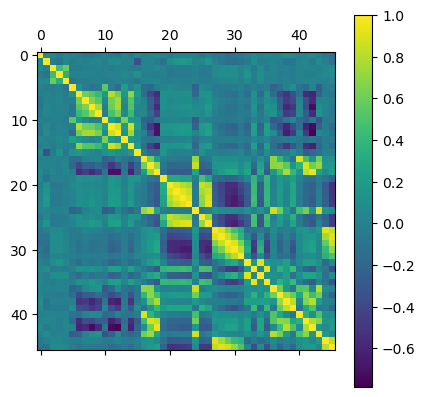

In [6]:
print(dat.shape)
plt.figure(figsize=(16,16))
plt.matshow(dat.corr())
plt.colorbar()
plt.show()

In [7]:
dat.iloc[:,8:(dat.shape[1]+1)]

,err_i,err_z,u,g,r,cModelMag_u,cModelMag_g,extinction_u,spectroFlux_u,spectroFlux_g,...,snMedian_u,snMedian_g,snMedian_r,snMedian_z,spectroFlux_u_log,spectroFlux_g_log,spectroFlux_r_log,spectroSynFlux_u_log,spectroSkyFlux_u_log,spectroSkyFlux_g_log
0,0.018013,0.040937,26.51590,20.83260,19.14239,25.44939,20.58232,0.139218,1.843202,1.929815,...,0.576332,1.292815,6.331930,5.575915,1.044931,1.074939,2.450348,0.401727,1.849118,2.464194
1,0.012527,0.034158,23.94815,20.59670,18.84989,23.63865,20.31554,0.136028,-0.593195,2.790346,...,-0.086997,1.442635,6.341427,6.550737,-0.465741,1.332457,2.730809,0.432600,1.929354,2.567525
2,0.016462,0.037736,24.58463,20.32992,18.35835,22.61887,20.54909,0.100681,-0.097102,1.254959,...,0.219810,1.025995,4.895129,4.434257,-0.092672,0.813132,2.304578,-0.063325,1.801197,2.848447
3,0.016470,0.040522,22.87946,20.78036,18.99024,21.89157,20.48506,0.083290,1.555073,2.429104,...,0.482978,1.104518,5.988503,5.339622,0.938081,1.232299,2.691568,0.313904,2.566778,3.293543
4,0.019496,0.066391,21.94542,20.49281,18.71999,20.19044,20.65470,0.139147,0.573039,1.165027,...,0.507682,0.932904,4.582425,4.019793,0.453009,0.772433,2.161553,0.216008,2.530823,2.962727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1181,0.083348,0.237379,22.54918,22.35385,21.71154,21.86404,22.37540,0.176112,0.752093,1.193742,...,0.332343,1.081129,1.896604,2.261250,0.560811,0.785609,1.275903,0.556432,2.127728,2.421793
1182,0.165256,0.300073,23.73355,23.25990,22.01872,22.14837,22.92971,0.089269,0.598694,0.520096,...,0.285197,0.469250,0.629302,0.521479,0.469187,0.418774,0.632744,0.326178,2.186264,2.437899
1183,0.085530,0.205889,25.55923,22.01511,21.09115,24.32553,22.44417,0.205386,0.955948,0.540339,...,0.250212,0.488000,1.307291,1.570632,0.670875,0.432003,1.022854,0.206494,2.251119,2.391742
1184,0.124358,0.335665,23.20477,23.15176,22.11319,22.38347,23.18616,0.144588,0.654925,0.576918,...,0.324380,0.525078,0.962452,1.200776,0.503756,0.455472,0.835192,0.283838,1.816156,2.280585


In [8]:
X_inter = dat.iloc[:,10:(dat.shape[1]+1)].values
# inter_mat = PolynomialFeatures(degree=3, interaction_only=False, 
#                                 include_bias=False).fit_transform(X_inter)
inter_mat = SplineTransformer(degree=3, n_knots=40, extrapolation="periodic", 
                              include_bias=True).fit_transform(X_inter)

In [9]:
inter_mat.shape

(1186, 1404)

In [10]:
## This chunk can only be run once
X = np.concatenate([dat[['RA', 'DEC', 'dist_DirFila_angdiam', 'dist_DirKnots_angdiam', 'dist_DirModes_angdiam']].values, 
                    inter_mat], axis=1)
x_gal = X[X.shape[0]-1,:]
y_gal = Y[Y.shape[0]-1]
X = X[:(X.shape[0]-1),:]
Y = Y[:(Y.shape[0]-1)]
log_Y = log_Y[:(log_Y.shape[0]-1)]
R = R[:(R.shape[0]-1)]
X.shape

(1185, 1409)

In [11]:
dat_new = pd.DataFrame(np.concatenate([X, Y.reshape(-1,1)], axis=1))
dat_new.to_csv('HighD_dat_final.csv', index=False)

In [12]:
## Lasso pilot estimator
beta_pilot, sigma_pilot = ScaledLasso(X=X[R == 1,:], Y=log_Y[R == 1], lam0='univ') 

In [13]:
print(sum(abs(beta_pilot) > 1e-6))
beta_pilot[:10]

6


array([ 0.04910866,  0.20074543, -0.02918641,  0.06195621,  0.09520945,
        0.        ,  0.        ,  0.        , -0.        ,  0.        ])

### Debiasing Program With LR Estimated Propensity Scores

In [16]:
## Propensity score estimation (logistic regression CV)
d = X.shape[1]
n = X.shape[0]
zeta = np.logspace(-1, np.log10(300), 20)*np.sqrt(np.log(d)/n)
lr = LogisticRegressionCV(Cs=1/zeta, cv=5, penalty='l1', scoring='neg_log_loss', 
                           solver='liblinear', tol=1e-6, max_iter=10000).fit(X, R)
prop_score1 = lr.predict_proba(X)[:,1]

In [42]:
d = X.shape[1]
n = X.shape[0]

for i in [1,2,3]:
    if i == 1:
        ## x1 (color err v.s. stellar mass)
        x = np.zeros((d,))
        x[5:10] = 1
        gamma_n_lst = np.linspace(1e-4, np.max(abs(x)), 41)
    if i == 2:
        ## x2 (dist to filaments v.s. stellar mass)
        x = np.zeros((d,))
        x[2] = 1
        gamma_n_lst = np.linspace(1e-4, np.max(abs(x)), 41)
    if i == 3:
        ## x3 (new queried galaxy)
        x = x_gal
        gamma_n_lst = np.logspace(-4, np.log10(np.max(abs(x))), 41)

    cv_fold = 5
    kf = KFold(n_splits=cv_fold, shuffle=True, random_state=0)
    f_ind = 0
    dual_loss = np.zeros((cv_fold, len(gamma_n_lst)))
    for train_ind, test_ind in kf.split(X):
        X_train = X[train_ind,:]
        X_test = X[test_ind,:]
        prop_score_train = prop_score1[train_ind]
        prop_score_test = prop_score1[test_ind]
        
        for j in range(len(gamma_n_lst)):
            try:
                w_train = DebiasProg(X=X_train.copy(), x=x, Pi=np.diag(prop_score_train), gamma_n=gamma_n_lst[j])
            except:
                w_train = np.nan*np.ones((n,))
            if any(np.isnan(w_train)):
                print(r'The primal debiasing program for this fold of the data is '\
                      'not feasible when \gamma/n='+str(round(gamma_n_lst[j], 4))+'!')
                dual_loss[f_ind, j] = np.nan
            else:
                ll_train = DualCD(X=X_train, x=x, Pi=np.diag(prop_score_train), gamma_n=gamma_n_lst[j], 
                                   ll_init=None, eps=1e-5, max_iter=5000)
                dual_gap = abs(w_train + np.dot(X_train, ll_train)/(2*np.sqrt(X_train.shape[0])))
                if sum(dual_gap > 1e-3) > 0:
                    print(r'The strong duality between primal and dual programs does not satisfy '\
                          'when \gamma/n='+str(round(gamma_n_lst[j], 4))+'!')
                    dual_loss[f_ind, j] = np.nan
                else:
                    dual_loss[f_ind, j] = DualObj(X_test, x=x, Pi=np.diag(prop_score_test), 
                                                   ll_cur=ll_train, gamma_n=gamma_n_lst[j])
        f_ind = f_ind + 1
    mean_dual_loss = np.mean(dual_loss, axis=0)
    std_dual_loss = np.std(dual_loss, axis=0, ddof=1)/np.sqrt(cv_fold)
    
    # Different rules for choosing the tuning parameter
    para_rule = ['1se', 'mincv', 'minfeas']
    for rule in para_rule:
        if rule == 'mincv':
            gamma_n_opt = gamma_n_lst[np.nanargmin(mean_dual_loss)]
        if rule == '1se':
            One_SE = (mean_dual_loss > np.nanmin(mean_dual_loss) + std_dual_loss[np.nanargmin(mean_dual_loss)]) & \
            (gamma_n_lst < gamma_n_lst[np.nanargmin(mean_dual_loss)])
            if sum(One_SE) == 0:
                One_SE = np.full((len(gamma_n_lst),), True)
            gamma_n_lst1 = gamma_n_lst[One_SE]
            gamma_n_opt = gamma_n_lst1[np.nanargmin(mean_dual_loss[One_SE])]
        if rule == 'minfeas':
            gamma_n_opt = np.min(gamma_n_lst[~np.isnan(mean_dual_loss)])
            
        # Solve the primal and dual on the original dataset
        w_obs = DebiasProg(X=X.copy(), x=x, Pi=np.diag(prop_score1), gamma_n=gamma_n_opt)
        ll_obs = DualCD(X=X, x=x, Pi=np.diag(prop_score1), gamma_n=gamma_n_opt, ll_init=None, eps=1e-5, max_iter=5000)
        
        # Store the results
        m_deb = np.dot(x, beta_pilot) + np.sum(w_obs * R * (log_Y - np.dot(X, beta_pilot)))/np.sqrt(n)
        asym_var = np.sqrt(np.sum(prop_score1 * w_obs**2)/n)
        sigma_hat = sigma_pilot
        
        debias_res = pd.DataFrame({'m_deb': [m_deb], 'asym_sd': [asym_var], 
                                   'sigma_hat': [sigma_hat], 'gamma_n':[gamma_n_opt]})
        debias_res.to_csv('./debias_sdss_res/SDSS_stellar_mass_inf_x'+str(i)+'_d'+str(d)+'_n'+str(n)+'_'+str(rule)+'_LR_final.csv', index=False)

The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.0001!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.0251!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.0501!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.0751!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.1001!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.1251!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.1501!
The primal debiasing program is infeasibl

The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.525!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.55!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.575!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.6!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.625!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.65!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.675!
The primal debiasing program is infeasible!
The prim

The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.0501!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.0751!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.1001!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.1251!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.1501!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.1751!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.2001!
The primal debiasing program is infeasibl

The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.575!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.6!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.625!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.65!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.675!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.7!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.725!
The primal debiasing program is infeasible!
The prima

The strong duality between primal and dual programs does not satisfy when \gamma/n=0.006!
The coordinate descent algorithm has reached its maximum number of iterations: 5000!
The strong duality between primal and dual programs does not satisfy when \gamma/n=0.0085!
The coordinate descent algorithm has reached its maximum number of iterations: 5000!
The strong duality between primal and dual programs does not satisfy when \gamma/n=0.012!
The coordinate descent algorithm has reached its maximum number of iterations: 5000!
The coordinate descent algorithm has reached its maximum number of iterations: 5000!
The coordinate descent algorithm has reached its maximum number of iterations: 5000!
The coordinate descent algorithm has reached its maximum number of iterations: 5000!
The strong duality between primal and dual programs does not satisfy when \gamma/n=0.0001!
The coordinate descent algorithm has reached its maximum number of iterations: 5000!
The strong duality between primal and dual 

The strong duality between primal and dual programs does not satisfy when \gamma/n=0.003!
The coordinate descent algorithm has reached its maximum number of iterations: 5000!
The strong duality between primal and dual programs does not satisfy when \gamma/n=0.0043!
The coordinate descent algorithm has reached its maximum number of iterations: 5000!
The strong duality between primal and dual programs does not satisfy when \gamma/n=0.006!
The coordinate descent algorithm has reached its maximum number of iterations: 5000!
The strong duality between primal and dual programs does not satisfy when \gamma/n=0.0085!
The coordinate descent algorithm has reached its maximum number of iterations: 5000!
The strong duality between primal and dual programs does not satisfy when \gamma/n=0.012!
The coordinate descent algorithm has reached its maximum number of iterations: 5000!
The strong duality between primal and dual programs does not satisfy when \gamma/n=0.0168!
The coordinate descent algorithm

### Debiasing Program With NN Estimated Propensity Scores

In [14]:
## Propensity score estimation (NN)
lr_NN = MLPClassifier(hidden_layer_sizes=(80,50,), activation='relu', 
                       random_state=None, learning_rate='adaptive', 
                       learning_rate_init=0.001, max_iter=1000).fit(X, R)
prop_score2 = lr_NN.predict_proba(X)[:,1]
min(prop_score2)

4.85365387215157e-08

In [15]:
d = X.shape[1]
n = X.shape[0]

for i in [1,2,3]:
    if i == 1:
        ## x1 (color err v.s. stellar mass)
        x = np.zeros((d,))
        x[5:10] = 1
        gamma_n_lst = np.linspace(1e-4, np.max(abs(x)), 41)
    if i == 2:
        ## x2 (dist to filaments v.s. stellar mass)
        x = np.zeros((d,))
        x[2] = 1
        gamma_n_lst = np.linspace(1e-4, np.max(abs(x)), 41)
    if i == 3:
        ## x3 (new queried galaxy)
        x = x_gal
        gamma_n_lst = np.logspace(-4, np.log10(np.max(abs(x))), 41)

    cv_fold = 5
    kf = KFold(n_splits=cv_fold, shuffle=True, random_state=0)
    f_ind = 0
    dual_loss = np.zeros((cv_fold, len(gamma_n_lst)))
    for train_ind, test_ind in kf.split(X):
        X_train = X[train_ind,:]
        X_test = X[test_ind,:]
        prop_score_train = prop_score2[train_ind]
        prop_score_test = prop_score2[test_ind]
        
        for j in range(len(gamma_n_lst)):
            try:
                w_train = DebiasProg(X=X_train.copy(), x=x, Pi=np.diag(prop_score_train), gamma_n=gamma_n_lst[j])
            except:
                w_train = np.nan*np.ones((n,))
            if any(np.isnan(w_train)):
                print(r'The primal debiasing program for this fold of the data is '\
                      'not feasible when \gamma/n='+str(round(gamma_n_lst[j], 4))+'!')
                dual_loss[f_ind, j] = np.nan
            else:
                ll_train = DualCD(X=X_train, x=x, Pi=np.diag(prop_score_train), gamma_n=gamma_n_lst[j], 
                                   ll_init=None, eps=1e-5, max_iter=5000)
                dual_gap = abs(w_train + np.dot(X_train, ll_train)/(2*np.sqrt(X_train.shape[0])))
                if sum(dual_gap > 1e-3) > 0:
                    print(r'The strong duality between primal and dual programs does not satisfy '\
                          'when \gamma/n='+str(round(gamma_n_lst[j], 4))+'!')
                    dual_loss[f_ind, j] = np.nan
                else:
                    dual_loss[f_ind, j] = DualObj(X_test, x=x, Pi=np.diag(prop_score_test), 
                                                   ll_cur=ll_train, gamma_n=gamma_n_lst[j])
        f_ind = f_ind + 1
    mean_dual_loss = np.mean(dual_loss, axis=0)
    std_dual_loss = np.std(dual_loss, axis=0, ddof=1)/np.sqrt(cv_fold)
    
    # Different rules for choosing the tuning parameter
    para_rule = ['1se', 'mincv', 'minfeas']
    for rule in para_rule:
        if rule == 'mincv':
            gamma_n_opt = gamma_n_lst[np.nanargmin(mean_dual_loss)]
        if rule == '1se':
            One_SE = (mean_dual_loss > np.nanmin(mean_dual_loss) + std_dual_loss[np.nanargmin(mean_dual_loss)]) & \
            (gamma_n_lst < gamma_n_lst[np.nanargmin(mean_dual_loss)])
            if sum(One_SE) == 0:
                One_SE = np.full((len(gamma_n_lst),), True)
            gamma_n_lst1 = gamma_n_lst[One_SE]
            gamma_n_opt = gamma_n_lst1[np.nanargmin(mean_dual_loss[One_SE])]
        if rule == 'minfeas':
            gamma_n_opt = np.min(gamma_n_lst[~np.isnan(mean_dual_loss)])
            
        # Solve the primal and dual on the original dataset
        w_obs = DebiasProg(X=X.copy(), x=x, Pi=np.diag(prop_score2), gamma_n=gamma_n_opt)
        ll_obs = DualCD(X=X, x=x, Pi=np.diag(prop_score2), gamma_n=gamma_n_opt, ll_init=None, eps=1e-5, max_iter=5000)
        
        # Store the results
        m_deb = np.dot(x, beta_pilot) + np.sum(w_obs * R * (log_Y - np.dot(X, beta_pilot)))/np.sqrt(n)
        asym_var = np.sqrt(np.sum(prop_score2 * w_obs**2)/n)
        sigma_hat = sigma_pilot
        
        debias_res = pd.DataFrame({'m_deb': [m_deb], 'asym_sd': [asym_var], 
                                   'sigma_hat': [sigma_hat], 'gamma_n':[gamma_n_opt]})
        debias_res.to_csv('./debias_sdss_res/SDSS_stellar_mass_inf_x'+str(i)+'_d'+str(d)+'_n'+str(n)+'_'+str(rule)+'_NN_final.csv', index=False)

The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.0001!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.0251!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.0501!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.0751!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.1001!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.1251!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.1501!
The primal debiasing program is infeasibl

/media/yikun/Disk_D1/Graduate School/Research Projects/Debiased IPW Lasso/Codes/SDSS_Applications/debias_prog.py:203: RuntimeWarning: invalid value encountered in double_scalars
  up_val = SoftThres(-np.dot(A_kj, ll_cur)/(2*n) - x[j], lamb=gamma_n)/(A[j,j]/(2*n))


The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.0001!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.0251!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.0501!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.0751!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.1001!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.1251!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.1501!
The primal debiasing program is infeasibl

The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.525!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.55!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.575!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.6!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.625!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.65!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.675!
The primal debiasing program is infeasible!
The prim

The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.0501!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.0751!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.1001!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.1251!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.1501!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.1751!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.2001!
The primal debiasing program is infeasibl

The strong duality between primal and dual programs does not satisfy when \gamma/n=0.006!
The coordinate descent algorithm has reached its maximum number of iterations: 5000!
The strong duality between primal and dual programs does not satisfy when \gamma/n=0.0085!
The coordinate descent algorithm has reached its maximum number of iterations: 5000!
The strong duality between primal and dual programs does not satisfy when \gamma/n=0.012!
The coordinate descent algorithm has reached its maximum number of iterations: 5000!
The strong duality between primal and dual programs does not satisfy when \gamma/n=0.0168!
The coordinate descent algorithm has reached its maximum number of iterations: 5000!
The strong duality between primal and dual programs does not satisfy when \gamma/n=0.0237!
The coordinate descent algorithm has reached its maximum number of iterations: 5000!
The strong duality between primal and dual programs does not satisfy when \gamma/n=0.0334!
The coordinate descent algorith

The coordinate descent algorithm has reached its maximum number of iterations: 5000!
The strong duality between primal and dual programs does not satisfy when \gamma/n=0.0015!
The coordinate descent algorithm has reached its maximum number of iterations: 5000!
The strong duality between primal and dual programs does not satisfy when \gamma/n=0.0022!
The coordinate descent algorithm has reached its maximum number of iterations: 5000!
The strong duality between primal and dual programs does not satisfy when \gamma/n=0.003!
The coordinate descent algorithm has reached its maximum number of iterations: 5000!
The strong duality between primal and dual programs does not satisfy when \gamma/n=0.0043!
The coordinate descent algorithm has reached its maximum number of iterations: 5000!
The strong duality between primal and dual programs does not satisfy when \gamma/n=0.006!
The coordinate descent algorithm has reached its maximum number of iterations: 5000!
The strong duality between primal and

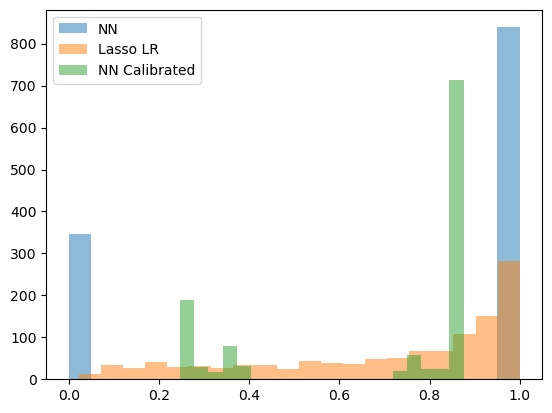

In [19]:
plt.hist(prop_score2, bins=20, alpha=0.5, label='NN')
plt.hist(prop_score1, bins=20, alpha=0.5, label='Lasso LR')
plt.hist(prop_score3, bins=20, alpha=0.5, label='NN Calibrated')
plt.legend()
plt.show()

### Debiasing Program With Calibrated NN Estimated Propensity Scores

In [17]:
## Propensity score estimation (NNcal)
NN_base = MLPClassifier(hidden_layer_sizes=(80,50,), activation='relu', 
                       random_state=None, learning_rate='adaptive', 
                       learning_rate_init=0.001, max_iter=1000)
lr2_NN = CalibratedClassifierCV(NN_base, method='sigmoid', cv=5).fit(X, R)
prop_score3 = lr2_NN.predict_proba(X)[:,1]
min(prop_score3)

0.2463227683036396

In [18]:
d = X.shape[1]
n = X.shape[0]

for i in [1,2,3]:
    if i == 1:
        ## x1 (color err v.s. stellar mass)
        x = np.zeros((d,))
        x[5:10] = 1
        gamma_n_lst = np.linspace(1e-4, np.max(abs(x)), 41)
    if i == 2:
        ## x2 (dist to filaments v.s. stellar mass)
        x = np.zeros((d,))
        x[2] = 1
        gamma_n_lst = np.linspace(1e-4, np.max(abs(x)), 41)
    if i == 3:
        ## x3 (new queried galaxy)
        x = x_gal
        gamma_n_lst = np.logspace(-4, np.log10(np.max(abs(x))), 41)

    cv_fold = 5
    kf = KFold(n_splits=cv_fold, shuffle=True, random_state=0)
    f_ind = 0
    dual_loss = np.zeros((cv_fold, len(gamma_n_lst)))
    for train_ind, test_ind in kf.split(X):
        X_train = X[train_ind,:]
        X_test = X[test_ind,:]
        prop_score_train = prop_score3[train_ind]
        prop_score_test = prop_score3[test_ind]
        
        for j in range(len(gamma_n_lst)):
            try:
                w_train = DebiasProg(X=X_train.copy(), x=x, Pi=np.diag(prop_score_train), gamma_n=gamma_n_lst[j])
            except:
                w_train = np.nan*np.ones((n,))
            if any(np.isnan(w_train)):
                print(r'The primal debiasing program for this fold of the data is '\
                      'not feasible when \gamma/n='+str(round(gamma_n_lst[j], 4))+'!')
                dual_loss[f_ind, j] = np.nan
            else:
                ll_train = DualCD(X=X_train, x=x, Pi=np.diag(prop_score_train), gamma_n=gamma_n_lst[j], 
                                   ll_init=None, eps=1e-5, max_iter=5000)
                dual_gap = abs(w_train + np.dot(X_train, ll_train)/(2*np.sqrt(X_train.shape[0])))
                if sum(dual_gap > 1e-3) > 0:
                    print(r'The strong duality between primal and dual programs does not satisfy '\
                          'when \gamma/n='+str(round(gamma_n_lst[j], 4))+'!')
                    dual_loss[f_ind, j] = np.nan
                else:
                    dual_loss[f_ind, j] = DualObj(X_test, x=x, Pi=np.diag(prop_score_test), 
                                                   ll_cur=ll_train, gamma_n=gamma_n_lst[j])
        f_ind = f_ind + 1
    mean_dual_loss = np.mean(dual_loss, axis=0)
    std_dual_loss = np.std(dual_loss, axis=0, ddof=1)/np.sqrt(cv_fold)
    
    # Different rules for choosing the tuning parameter
    para_rule = ['1se', 'mincv', 'minfeas']
    for rule in para_rule:
        if rule == 'mincv':
            gamma_n_opt = gamma_n_lst[np.nanargmin(mean_dual_loss)]
        if rule == '1se':
            One_SE = (mean_dual_loss > np.nanmin(mean_dual_loss) + std_dual_loss[np.nanargmin(mean_dual_loss)]) & \
            (gamma_n_lst < gamma_n_lst[np.nanargmin(mean_dual_loss)])
            if sum(One_SE) == 0:
                One_SE = np.full((len(gamma_n_lst),), True)
            gamma_n_lst1 = gamma_n_lst[One_SE]
            gamma_n_opt = gamma_n_lst1[np.nanargmin(mean_dual_loss[One_SE])]
        if rule == 'minfeas':
            gamma_n_opt = np.min(gamma_n_lst[~np.isnan(mean_dual_loss)])
            
        # Solve the primal and dual on the original dataset
        w_obs = DebiasProg(X=X.copy(), x=x, Pi=np.diag(prop_score3), gamma_n=gamma_n_opt)
        ll_obs = DualCD(X=X, x=x, Pi=np.diag(prop_score3), gamma_n=gamma_n_opt, ll_init=None, eps=1e-5, max_iter=5000)
        
        # Store the results
        m_deb = np.dot(x, beta_pilot) + np.sum(w_obs * R * (log_Y - np.dot(X, beta_pilot)))/np.sqrt(n)
        asym_var = np.sqrt(np.sum(prop_score3 * w_obs**2)/n)
        sigma_hat = sigma_pilot
        
        debias_res = pd.DataFrame({'m_deb': [m_deb], 'asym_sd': [asym_var], 
                                   'sigma_hat': [sigma_hat], 'gamma_n':[gamma_n_opt]})
        debias_res.to_csv('./debias_sdss_res/SDSS_stellar_mass_inf_x'+str(i)+'_d'+str(d)+'_n'+str(n)+'_'+str(rule)+'_NNcal_final.csv', index=False)

The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.0001!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.0251!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.0501!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.0751!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.1001!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.1251!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.1501!
The primal debiasing program is infeasibl

/media/yikun/Disk_D1/Graduate School/Research Projects/Debiased IPW Lasso/Codes/SDSS_Applications/debias_prog.py:203: RuntimeWarning: invalid value encountered in double_scalars
  up_val = SoftThres(-np.dot(A_kj, ll_cur)/(2*n) - x[j], lamb=gamma_n)/(A[j,j]/(2*n))


The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.0001!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.0251!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.0501!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.0751!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.1001!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.1251!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.1501!
The primal debiasing program is infeasibl

The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.525!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.55!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.575!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.6!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.625!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.65!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.675!
The primal debiasing program is infeasible!
The prim

The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.0501!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.0751!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.1001!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.1251!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.1501!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.1751!
The primal debiasing program is infeasible!
The primal debiasing program for this fold of the data is not feasible when \gamma/n=0.2001!
The primal debiasing program is infeasibl

The strong duality between primal and dual programs does not satisfy when \gamma/n=0.006!
The coordinate descent algorithm has reached its maximum number of iterations: 5000!
The strong duality between primal and dual programs does not satisfy when \gamma/n=0.0085!
The coordinate descent algorithm has reached its maximum number of iterations: 5000!
The strong duality between primal and dual programs does not satisfy when \gamma/n=0.012!
The coordinate descent algorithm has reached its maximum number of iterations: 5000!
The coordinate descent algorithm has reached its maximum number of iterations: 5000!
The coordinate descent algorithm has reached its maximum number of iterations: 5000!
The strong duality between primal and dual programs does not satisfy when \gamma/n=0.0001!
The coordinate descent algorithm has reached its maximum number of iterations: 5000!
The strong duality between primal and dual programs does not satisfy when \gamma/n=0.0001!
The coordinate descent algorithm has 

The coordinate descent algorithm has reached its maximum number of iterations: 5000!
The strong duality between primal and dual programs does not satisfy when \gamma/n=0.0043!
The coordinate descent algorithm has reached its maximum number of iterations: 5000!
The strong duality between primal and dual programs does not satisfy when \gamma/n=0.006!
The coordinate descent algorithm has reached its maximum number of iterations: 5000!
The strong duality between primal and dual programs does not satisfy when \gamma/n=0.0085!
The coordinate descent algorithm has reached its maximum number of iterations: 5000!
The strong duality between primal and dual programs does not satisfy when \gamma/n=0.012!
The coordinate descent algorithm has reached its maximum number of iterations: 5000!
The coordinate descent algorithm has reached its maximum number of iterations: 5000!
The coordinate descent algorithm has reached its maximum number of iterations: 5000!
The strong duality between primal and dual 

In [21]:
n

1185

### Post Analysis

x1


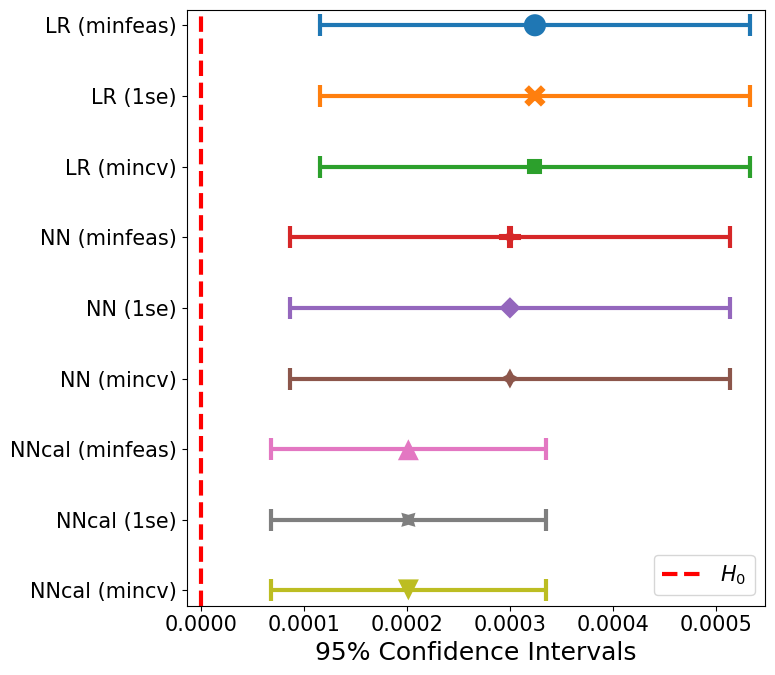

      m_deb   asym_sd  sigma_hat  gamma_n        Scenarios     ci_up  \
0  0.000324  0.000013   8.232237      1.0     LR (minfeas)  0.000534   
0  0.000324  0.000013   8.232237      1.0         LR (1se)  0.000534   
0  0.000324  0.000013   8.232237      1.0       LR (mincv)  0.000534   
0  0.000300  0.000013   8.232237      1.0     NN (minfeas)  0.000514   
0  0.000300  0.000013   8.232237      1.0         NN (1se)  0.000514   
0  0.000300  0.000013   8.232237      1.0       NN (mincv)  0.000514   
0  0.000201  0.000008   8.232237      1.0  NNcal (minfeas)  0.000335   
0  0.000201  0.000008   8.232237      1.0      NNcal (1se)  0.000335   
0  0.000201  0.000008   8.232237      1.0    NNcal (mincv)  0.000335   

     ci_low   ci_half  
0  0.000115  0.000209  
0  0.000115  0.000209  
0  0.000115  0.000209  
0  0.000086  0.000214  
0  0.000086  0.000214  
0  0.000086  0.000214  
0  0.000068  0.000134  
0  0.000068  0.000134  
0  0.000068  0.000134  
x2


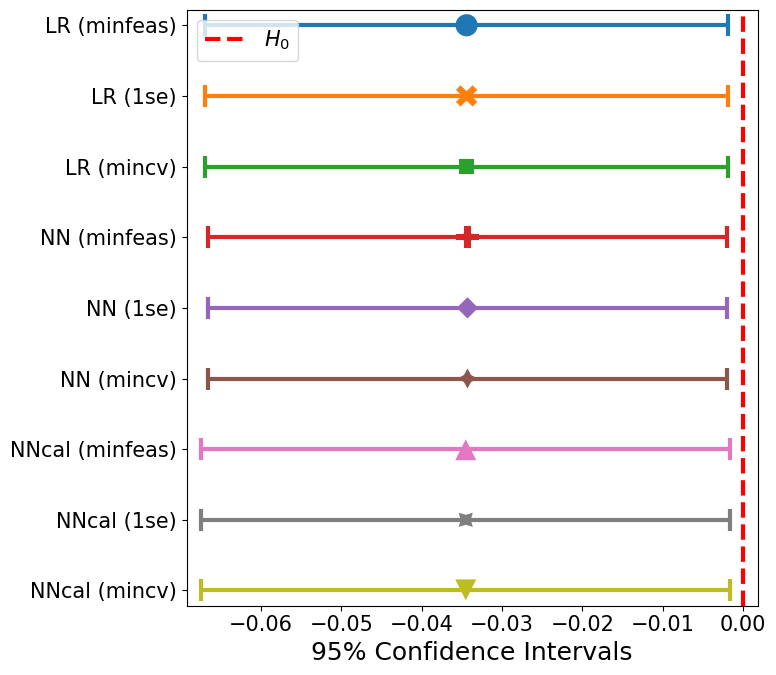

      m_deb   asym_sd  sigma_hat   gamma_n        Scenarios     ci_up  \
0 -0.034415  0.002016   8.232237  0.025097     LR (minfeas) -0.001886   
0 -0.034415  0.002016   8.232237  0.025097         LR (1se) -0.001886   
0 -0.034415  0.002016   8.232237  0.025097       LR (mincv) -0.001886   
0 -0.034301  0.002004   8.232237  0.025097     NN (minfeas) -0.001969   
0 -0.034301  0.002004   8.232237  0.025097         NN (1se) -0.001969   
0 -0.034301  0.002004   8.232237  0.025097       NN (mincv) -0.001969   
0 -0.034520  0.002041   8.232237  0.025097  NNcal (minfeas) -0.001596   
0 -0.034520  0.002041   8.232237  0.025097      NNcal (1se) -0.001596   
0 -0.034520  0.002041   8.232237  0.025097    NNcal (mincv) -0.001596   

     ci_low   ci_half  
0 -0.066944  0.032529  
0 -0.066944  0.032529  
0 -0.066944  0.032529  
0 -0.066633  0.032332  
0 -0.066633  0.032332  
0 -0.066633  0.032332  
0 -0.067444  0.032924  
0 -0.067444  0.032924  
0 -0.067444  0.032924  
x3


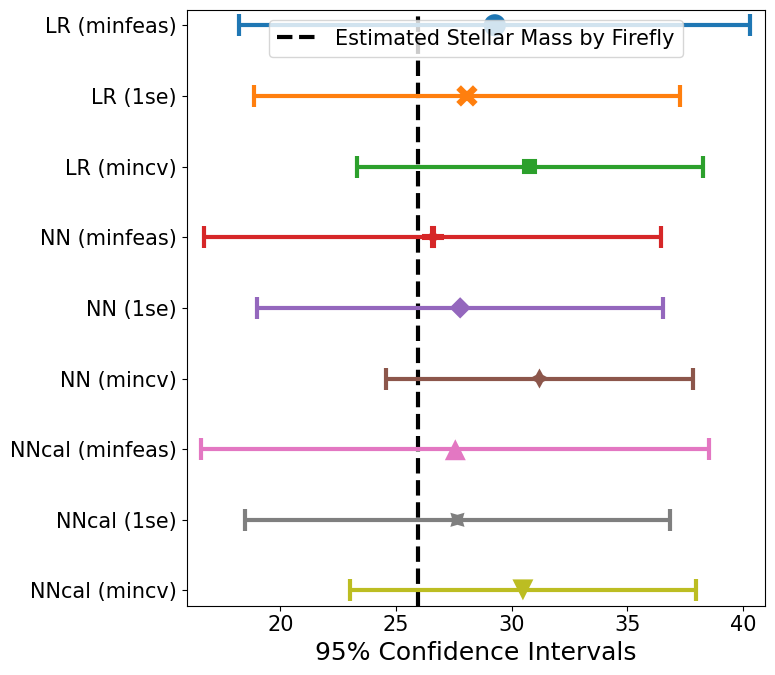

       m_deb   asym_sd  sigma_hat   gamma_n        Scenarios      ci_up  \
0  29.268757  0.684165   8.232237  0.023700     LR (minfeas)  40.307686   
0  28.063859  0.570703   8.232237  0.046945         LR (1se)  37.272090   
0  30.788265  0.463276   8.232237  0.092990       LR (mincv)  38.263174   
0  26.579234  0.611432   8.232237  0.046945     NN (minfeas)  36.444629   
0  27.770363  0.543681   8.232237  0.066072         NN (1se)  36.542592   
0  31.198899  0.412137   8.232237  0.130876       NN (mincv)  37.848686   
0  27.561351  0.680261   8.232237  0.023700  NNcal (minfeas)  38.537293   
0  27.652464  0.570081   8.232237  0.046945      NNcal (1se)  36.850650   
0  30.482684  0.463019   8.232237  0.092990    NNcal (mincv)  37.953447   

      ci_low    ci_half  
0  18.229828  11.038929  
0  18.855627   9.208232  
0  23.313357   7.474909  
0  16.713839   9.865395  
0  18.998134   8.772229  
0  24.549112   6.649787  
0  16.585409  10.975942  
0  18.454277   9.198187  
0  23.011921   

In [23]:
d = X.shape[1]
n = X.shape[0]

for k in [1,2,3]:
    debias_res_df = pd.DataFrame([])
    for prop_met in ['LR', 'NN', 'NNcal']:
        for rule in ['minfeas', '1se', 'mincv']:
            res_df = pd.read_csv('./debias_sdss_res/SDSS_stellar_mass_inf_x'+str(k)+'_d'+str(d)+'_n'+str(n)+'_'+str(rule)+'_'+str(prop_met)+'_final.csv')
            res_df['Scenarios'] = prop_met+' ('+str(rule)+')'
            debias_res_df = pd.concat([debias_res_df, res_df], axis=0)
            
    debias_res_df['ci_up'] = debias_res_df['m_deb'] + debias_res_df['asym_sd']*debias_res_df['sigma_hat']*scipy.stats.norm.ppf(1-0.05/2)
    debias_res_df['ci_low'] = debias_res_df['m_deb'] - debias_res_df['asym_sd']*debias_res_df['sigma_hat']*scipy.stats.norm.ppf(1-0.05/2)
    debias_res_df['ci_half'] = debias_res_df['asym_sd']*debias_res_df['sigma_hat']*scipy.stats.norm.ppf(1-0.05/2)
    
#     refit_df = pd.read_csv('./debias_sdss_res/SDSS_stellar_mass_lasso_refit_x'+str(k)+'_d'+str(d)+'_n'+str(n)+'.csv')
#     refit_res_df = pd.DataFrame({'m_deb': refit_df['m_deb'], 'asym_sd': refit_df['asym_sd'], })
    
    print('x'+str(k))
    plt.rcParams.update({'font.size': 15})
    plt.figure(figsize=(8,7))
    # lines={'linestyle': 'None'}
    # plt.rc('lines', **lines)
    sns.scatterplot(y='Scenarios', x='m_deb', data=debias_res_df, hue='Scenarios', style='Scenarios',
                    s=300, legend=False)
    if k == 3:
        plt.axvline(x=np.log(y_gal), color='black', linestyle='dashed', linewidth=3, label='Estimated Stellar Mass by Firefly')
    else:
        plt.axvline(x=0, color='red', linestyle='dashed', linewidth=3, label=r'$H_0$')
    for pos, y, err in zip(debias_res_df['Scenarios'], debias_res_df['m_deb'], debias_res_df['ci_half']):
        plt.errorbar(y, pos, xerr=err, lw=3, ls='none', capsize=8, capthick=3)
    # plt.xticks(rotation=45)
    plt.ylabel('')
    plt.xlabel('95% Confidence Intervals', size=18)
    plt.legend()
    
    # refx2 = [0.92, 0.952]
    # refy2 = [9.72, 11.28]
    # plt.hlines(refy2, xmin=refx2[0], xmax=refx2[1], color='black', linestyles='--', linewidth=2)
    # plt.vlines(refx2, ymin=refy2[0], ymax=refy2[1], color='black', linestyles='--', linewidth=2)
    
    plt.margins(x=0.027, y=0.027)
    plt.tight_layout()
    plt.show()
    
    print(debias_res_df)

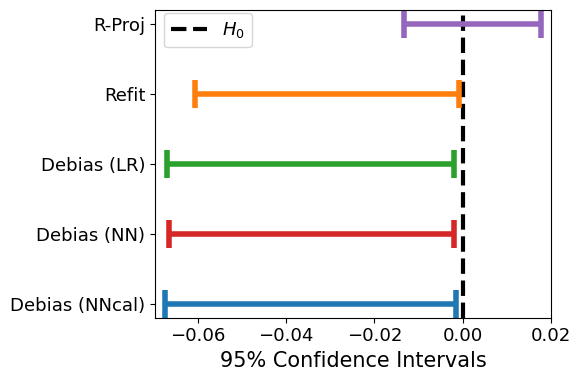

In [28]:
d = X.shape[1]
n = X.shape[0]

# stellar mass v.s. distance to filaments
k = 2
x = np.zeros((d,))
x[2] = 1
    
debias_res_df = pd.DataFrame([])
for prop_met in ['LR', 'NN', 'NNcal']:
    for rule in ['1se']:
        res_df = pd.read_csv('./debias_sdss_res/SDSS_stellar_mass_inf_x'+str(k)+'_d'+str(d)+'_n'+str(n)+'_'+str(rule)+'_'+str(prop_met)+'_final.csv')
        res_df['Scenarios'] = 'Debias ('+prop_met+')'
        debias_res_df = pd.concat([debias_res_df, res_df], axis=0)
        
debias_res_df['ci_up'] = debias_res_df['m_deb'] + debias_res_df['asym_sd']*debias_res_df['sigma_hat']*scipy.stats.norm.ppf(1-0.05/2)
debias_res_df['ci_low'] = debias_res_df['m_deb'] - debias_res_df['asym_sd']*debias_res_df['sigma_hat']*scipy.stats.norm.ppf(1-0.05/2)
debias_res_df['ci_half'] = debias_res_df['asym_sd']*debias_res_df['sigma_hat']*scipy.stats.norm.ppf(1-0.05/2)

refit_df = pd.read_csv('./debias_sdss_res/SDSS_stellar_mass_lasso_refit_x'+str(k)+'_d'+str(d)+'_n'+str(n)+'.csv')
        
# refit_df['ci_up_norm'] = refit_df['m_deb'] + refit_df['asym_sd']*refit_df['sigma_hat']*scipy.stats.norm.ppf(1-0.05/2)
# refit_df['ci_low_norm'] = refit_df['m_deb'] - refit_df['asym_sd']*refit_df['sigma_hat']*scipy.stats.norm.ppf(1-0.05/2)
# refit_df['ci_half_norm'] = refit_df['asym_sd']*refit_df['sigma_hat']*scipy.stats.norm.ppf(1-0.05/2)

df = refit_df['df'].values
refit_df['ci_up_t'] = refit_df['m_deb'] + refit_df['asym_sd']*refit_df['sigma_hat']*scipy.stats.t.ppf(1 - 0.05/2, df=df)
refit_df['ci_low_t'] = refit_df['m_deb'] - refit_df['asym_sd']*refit_df['sigma_hat']*scipy.stats.t.ppf(1 - 0.05/2, df=df)
refit_df['ci_half_t'] = refit_df['asym_sd']*refit_df['sigma_hat']*scipy.stats.t.ppf(1 - 0.05/2, df=df)

# debias_res_df = pd.concat([debias_res_df, 
#                            pd.DataFrame({'m_deb': refit_df['m_deb'], 'asym_sd': refit_df['asym_sd'], 
#                                         'sigma_hat': refit_df['sigma_hat'], 'gamma_n': np.nan, 
#                                         'Scenarios': 'Refit (norm-ci)', 'ci_up': refit_df['ci_up_norm'],
#                                         'ci_low': refit_df['ci_low_norm'], 'ci_half': refit_df['ci_half_norm']})], axis=0)

debias_res_df = pd.concat([pd.DataFrame({'m_deb': refit_df['m_deb'], 'asym_sd': refit_df['asym_sd'], 
                                        'sigma_hat': refit_df['sigma_hat'], 'gamma_n': np.nan, 
                                        'Scenarios': 'Refit', 'ci_up': refit_df['ci_up_t'],
                                        'ci_low': refit_df['ci_low_t'], 'ci_half': refit_df['ci_half_t']}), 
                           debias_res_df], axis=0)

rproj_res = pd.read_csv('ridge_proj_95.csv')

debias_res_df = pd.concat([pd.DataFrame({'m_deb': [(rproj_res.iloc[2,0]+rproj_res.iloc[2,1])/2], 'asym_sd': np.nan, 
                                        'sigma_hat': np.nan, 'gamma_n': np.nan, 
                                        'Scenarios': 'R-Proj', 'ci_up': [rproj_res.iloc[2,1]],
                                        'ci_low': [rproj_res.iloc[2,0]], 'ci_half': [rproj_res.iloc[2,1] - rproj_res.iloc[2,0]]}), 
                           debias_res_df], axis=0)

colors = ['tab:purple', 'tab:orange', 'tab:green', 'tab:red', 'tab:blue']
# colors = mcp.gen_color(cmap="plasma", n=len(debias_res_df['Scenarios'].unique()))
col_pal = dict(zip(list(debias_res_df['Scenarios'].unique()), colors))

plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(6,4))
# lines={'linestyle': 'None'}
# plt.rc('lines', **lines)
sns.scatterplot(y='Scenarios', x='m_deb', data=debias_res_df, hue='Scenarios', style='Scenarios',
                s=1, legend=False)
plt.axvline(x=0, color='black', linestyle='dashed', linewidth=3, label=r'$H_0$')
for pos, y, err in zip(debias_res_df['Scenarios'], debias_res_df['m_deb'], debias_res_df['ci_half']):
    # plt.scatter(y, pos, s=100)
    plt.errorbar(y, pos, xerr=err, lw=4, ls='none', capsize=10, capthick=4, color=col_pal[pos])
plt.ylabel('')
plt.xlabel('95% Confidence Intervals', size=15)
plt.legend(loc='upper left', bbox_to_anchor=(0, 0.52, 0.5, 0.5))

plt.margins(x=0.027, y=0.05)
plt.tight_layout()
plt.savefig('../Figures/stellar_mass_x'+str(k)+'.pdf', bbox_inches='tight')

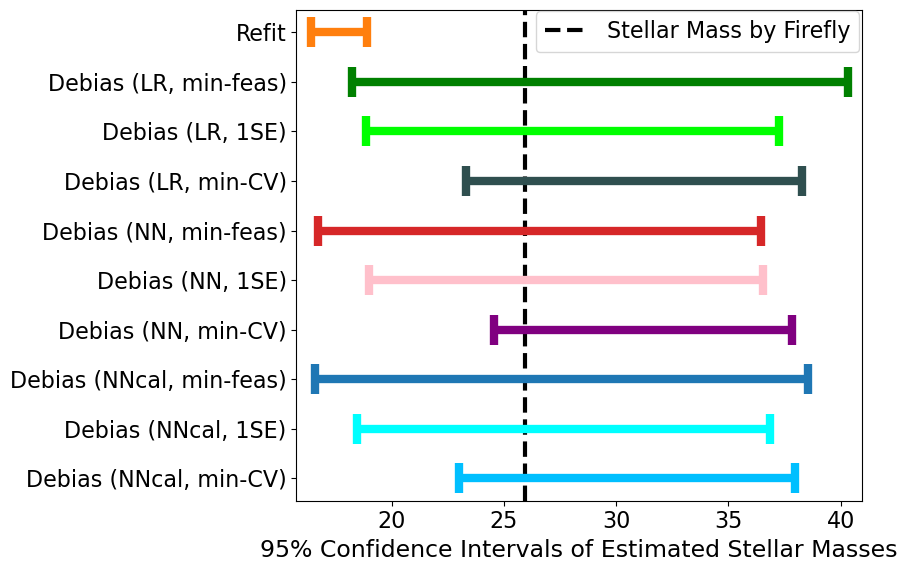

In [34]:
col_pal = {'Refit'}

d = X.shape[1]
n = X.shape[0]

# stellar mass v.s. distance to filaments
k = 3
x = x_gal
x[2] = 1
    
debias_res_df = pd.DataFrame([])
for prop_met in ['LR', 'NN', 'NNcal']:
    for rule in ['minfeas', '1se', 'mincv']:
        res_df = pd.read_csv('./debias_sdss_res/SDSS_stellar_mass_inf_x'+str(k)+'_d'+str(d)+'_n'+str(n)+'_'+str(rule)+'_'+str(prop_met)+'_final.csv')
        if rule == 'minfeas':
            rule = 'min-feas'
        if rule == '1se':
            rule = '1SE'
        if rule == 'mincv':
            rule = 'min-CV'
        res_df['Scenarios'] = 'Debias ('+prop_met+', '+str(rule)+')'
        debias_res_df = pd.concat([debias_res_df, res_df], axis=0)
        
debias_res_df['ci_up'] = debias_res_df['m_deb'] + debias_res_df['asym_sd']*debias_res_df['sigma_hat']*scipy.stats.norm.ppf(1-0.05/2)
debias_res_df['ci_low'] = debias_res_df['m_deb'] - debias_res_df['asym_sd']*debias_res_df['sigma_hat']*scipy.stats.norm.ppf(1-0.05/2)
debias_res_df['ci_half'] = debias_res_df['asym_sd']*debias_res_df['sigma_hat']*scipy.stats.norm.ppf(1-0.05/2)

refit_df = pd.read_csv('./debias_sdss_res/SDSS_stellar_mass_lasso_refit_x'+str(k)+'_d'+str(d)+'_n'+str(n)+'.csv')
        
# refit_df['ci_up_norm'] = refit_df['m_deb'] + refit_df['asym_sd']*refit_df['sigma_hat']*scipy.stats.norm.ppf(1-0.05/2)
# refit_df['ci_low_norm'] = refit_df['m_deb'] - refit_df['asym_sd']*refit_df['sigma_hat']*scipy.stats.norm.ppf(1-0.05/2)
# refit_df['ci_half_norm'] = refit_df['asym_sd']*refit_df['sigma_hat']*scipy.stats.norm.ppf(1-0.05/2)

df = refit_df['df'].values
refit_df['ci_up_t'] = refit_df['m_deb'] + refit_df['asym_sd']*refit_df['sigma_hat']*scipy.stats.t.ppf(1 - 0.05/2, df=df)
refit_df['ci_low_t'] = refit_df['m_deb'] - refit_df['asym_sd']*refit_df['sigma_hat']*scipy.stats.t.ppf(1 - 0.05/2, df=df)
refit_df['ci_half_t'] = refit_df['asym_sd']*refit_df['sigma_hat']*scipy.stats.t.ppf(1 - 0.05/2, df=df)

# debias_res_df = pd.concat([debias_res_df, 
#                            pd.DataFrame({'m_deb': refit_df['m_deb'], 'asym_sd': refit_df['asym_sd'], 
#                                         'sigma_hat': refit_df['sigma_hat'], 'gamma_n': np.nan, 
#                                         'Scenarios': 'Refit (norm-ci)', 'ci_up': refit_df['ci_up_norm'],
#                                         'ci_low': refit_df['ci_low_norm'], 'ci_half': refit_df['ci_half_norm']})], axis=0)

debias_res_df = pd.concat([pd.DataFrame({'m_deb': refit_df['m_deb'], 'asym_sd': refit_df['asym_sd'], 
                                        'sigma_hat': refit_df['sigma_hat'], 'gamma_n': np.nan, 
                                        'Scenarios': 'Refit', 'ci_up': refit_df['ci_up_t'],
                                        'ci_low': refit_df['ci_low_t'], 'ci_half': refit_df['ci_half_t']}), 
                           debias_res_df], axis=0)

colors = ['tab:orange', 'green', 'lime', 'darkslategrey', 'tab:red', 'pink', 'purple', 
          'tab:blue', 'cyan', 'deepskyblue']
col_pal = dict(zip(list(debias_res_df['Scenarios'].unique()), colors))

plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(9,6))
# lines={'linestyle': 'None'}
# plt.rc('lines', **lines)
sns.scatterplot(y='Scenarios', x='m_deb', data=debias_res_df, hue='Scenarios', style='Scenarios',
                s=1, legend=False)
if k == 3:
    plt.axvline(x=np.log(y_gal), color='black', linestyle='dashed', linewidth=3, label='Stellar Mass by Firefly')
else:
    plt.axvline(x=0, color='black', linestyle='dashed', linewidth=3, label=r'$H_0$')
for pos, y, err in zip(debias_res_df['Scenarios'], debias_res_df['m_deb'], debias_res_df['ci_half']):
    # plt.scatter(y, pos, s=100)
    plt.errorbar(y, pos, xerr=err, lw=6, ls='none', capsize=11, capthick=6, color=col_pal[pos])
plt.ylabel('')
plt.xlabel('95% Confidence Intervals of Estimated Stellar Masses', size=17)
plt.legend(loc='upper right', bbox_to_anchor=(0.515, 0.52, 0.5, 0.5))

plt.margins(x=0.027, y=0.05)
plt.tight_layout()
plt.savefig('../Figures/stellar_mass_x'+str(k)+'.pdf', bbox_inches='tight')

In [26]:
## Propensity score estimation (logistic regression CV)
d = X.shape[1]
n = X.shape[0]
zeta = np.logspace(-1, np.log10(300), 20)*np.sqrt(np.log(d)/n)
lr = LogisticRegressionCV(Cs=1/zeta, cv=5, penalty='l1', scoring='neg_log_loss', 
                           solver='liblinear', tol=1e-6, max_iter=10000).fit(X, R)
prop_score1 = lr.predict_proba(X)[:,1]


## Propensity score estimation (NN)
lr_NN = MLPClassifier(hidden_layer_sizes=(80,50,), activation='relu', 
                       random_state=None, learning_rate='adaptive', 
                       learning_rate_init=0.001, max_iter=1000).fit(X, R)
prop_score2 = lr_NN.predict_proba(X)[:,1]
min(prop_score2)

## Propensity score estimation (NNcal)
NN_base = MLPClassifier(hidden_layer_sizes=(80,50,), activation='relu', 
                       random_state=None, learning_rate='adaptive', 
                       learning_rate_init=0.001, max_iter=1000)
lr2_NN = CalibratedClassifierCV(NN_base, method='sigmoid', cv=5).fit(X, R)
prop_score3 = lr2_NN.predict_proba(X)[:,1]
min(prop_score3)

0.23836341616318268

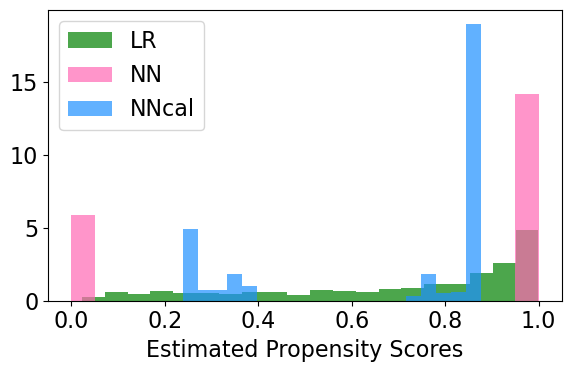

In [27]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(6,4))
plt.hist(prop_score1, bins=20, density=True, alpha=0.7, label='LR', color='green')
plt.hist(prop_score2, bins=20, density=True, alpha=0.7, label='NN', color='hotpink')
plt.hist(prop_score3, bins=20, density=True, alpha=0.7, label='NNcal', color='dodgerblue')
plt.xlabel('Estimated Propensity Scores')
plt.legend()
plt.tight_layout()
plt.savefig('../Figures/stellar_mass_prop_score.pdf', bbox_inches='tight')